# Application-to-Permit in New York City

This notebook (along with files associated with it) examines the timeline of job application to permit issuance in New York City.

## Introduction

### Construction Permit Process

Before a new building can begin construction it has to go through a long professional vetting process. The Department of Buildings (DOB) is the principal governmental organization responsible for overseeing the inspections and paperwork required for breaking ground.

The exact process, for the building manager involved, is summarized by [this handy chart](http://www1.nyc.gov/site/buildings/homeowner/dob-forms-applications.page). Here are the steps:

1. The applicant prefiles the application. Prefiling saves time, but not all applicants invoke it.
2. The applicant submits a work plan.
3. The plan is either professionally certified (a so-called "pro cert" or "self cert") or reviewed by the DOB.
4. The plan is approved or denied by the DOB.
5. Once a plan is approved, the applicant requests a work permit.
6. DOB issues a work permit.
7. Construction begins.

### Retrieving Construction Permits

Construction permits are retrieved as a part of the work done by the `Permit Issuance` companion notebook, which came first.

### Retrieving Application Jobs

DOB publishes a list of all [building job applications](https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2) as a part of the New York City Open Data Portal. This application is missing new building construction (which is posted to a seperate open dataset), but contains all of the information on the preceding timeline. Retrieving these permits is merely a matter of accessing, extracting, and filtering this dataset.

## Reading Job Application Data

In [1]:
import pandas as pd
import numpy as np
import arrow
from tqdm import tqdm

In [2]:
permits = pd.read_csv("DOB_Job_Application_Filings.csv")

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (13,14,16,19,38,59,60,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option("max_columns", 500)

In [4]:
permits['Job Status Descrp'].value_counts()[:-1] # Last one is a parsing error.

APPLICATION PROCESSED - ENTIRE              60217
PLAN EXAM - APPROVED                        36135
APPLICATION PROCESSED - ENTIRE              26308
PLAN EXAM - IN PROCESS                      23352
PLAN EXAM - APPROVED                        13840
PERMIT ISSUED - ENTIRE JOB/WORK             11975
PLAN EXAM - DISAPPROVED                      9453
PLAN EXAM - IN PROCESS                       7559
PERMIT ISSUED - ENTIRE JOB/WORK              7397
PRE-FILING                                   7052
PERMIT ISSUED - PARTIAL JOB                  5498
APPLICATION ASSIGNED TO PLAN EXAMINER        5216
PRE-FILING                                   3864
APPLICATION PROCESSED - NO PLAN EXAM         3554
PLAN EXAM - DISAPPROVED                      3291
PERMIT ISSUED - PARTIAL JOB                  2358
APPLICATION ASSIGNED TO PLAN EXAMINER        1411
APPLICATION PROCESSED - NO PLAN EXAM         1266
APPLICATION PROCESSED-PART-NO PAYMENT         378
APPLICATION PROCESSED-PART-NO PAYMENT         175


### `NB` Job Types

This record includes submissions for all job types, however we're only interested in new building construction jobs. This corresponds to records with a `JOB TYPE` of `NB`.

In [5]:
new_buildings = permits[permits['Job Type'] == 'NB']
all_bins = np.unique(new_buildings['Bin #'])
print("There are {0} new building records, corresponding with {1} buildings.".format(len(new_buildings), len(all_bins)))

There are 12481 new building records, corresponding with 6951 buildings.


In [6]:
new_buildings['Job Status Descrp'].value_counts()

APPLICATION PROCESSED - ENTIRE              4850
APPLICATION ASSIGNED TO PLAN EXAMINER       1860
APPLICATION PROCESSED - ENTIRE              1748
PRE-FILING                                  1712
PRE-FILING                                   751
APPLICATION ASSIGNED TO PLAN EXAMINER        553
PLAN EXAM - IN PROCESS                       351
PLAN EXAM - DISAPPROVED                      329
PLAN EXAM - DISAPPROVED                       96
PLAN EXAM - IN PROCESS                        80
PLAN EXAM - APPROVED                          76
PLAN EXAM - APPROVED                          45
APPLICATION PROCESSED-PART-NO PAYMENT         18
APPLICATION PROCESSED-PART-NO PAYMENT          6
PERMIT ISSUED - ENTIRE JOB/WORK                5
PERMIT ISSUED - PARTIAL JOB                    1
Name: Job Status Descrp, dtype: int64

In [7]:
permits['Job Type'].value_counts()

A2    150156
A3     44696
A1     14262
NB     12481
DM      5151
PA      2281
SC       877
SI       694
Name: Job Type, dtype: int64

Surprisingly there are almost no new building permit issuances!

This turned out to be a completely separate dataset (see `Permit to Occupancy Processing.ipynb`); the entries below are apparently included in this dataset in error.

In [8]:
new_buildings['Job Status Descrp'].value_counts()[['PERMIT ISSUED - ENTIRE JOB/WORK', 'PERMIT ISSUED - PARTIAL JOB']]

PERMIT ISSUED - ENTIRE JOB/WORK    5
PERMIT ISSUED - PARTIAL JOB        1
Name: Job Status Descrp, dtype: int64

## Application Data Join?

Initially I joined application data to the permit and occupancy data that comes from the `Permit to Occupancy.ipynb` processing. But on further reflection the addition of the application data has limited utility. This is because the sample of permits that we took was from May 2013 through the end of 2014. The permit is the last step of the application document trail, and our application data goes back the same amount, to May 2013.

This is the opposite of the problem that we have in examining permit-to-occupancy data, in which occupancy certificates come afterwards, so every site has at least 550 days of construction on the record.

This approach also ignores the fact that for every n permits, there are some n + k unfinished applications that never made it to the permiting stage at all.

## Application&mdash;Permit Join

Instead of doing the above, I will join the raw DOB datasets against one another and use that data to source my analysis.

Here are the variables we want to create:

* `Application Date` &mdash; The date that the first document that was not a pre-permit application was filed, based on data going back to April 2013.
* `Application Time` &mdash; The time between the first application and the issuance of the first building permit.

We will generate a dataset of document trail times for recent building construction permits by looking up dates in the `DOB_Job_Applications_Filings.csv` job listing for a sample of new buildings from (code below; same as in `Permit-to-Occupancy.ipynb`) `DOB_Permit_Issuance.csv` dating to 2016.

    new_building_permits = permits[(permits['Job Type'] == 'NB') &
                                   (permits['Permit Type'] == 'NB') &
                                   (permits['Permit Status'] == 'ISSUED') & 
                                   (permits['Filing Status'] == 'INITIAL') &
                                   (permits['Job doc. #'] == 1.0)]

In [9]:
jobs = pd.read_csv("DOB_Job_Application_Filings.csv")

In [10]:
permits = pd.read_csv("DOB_Permit_Issuance.csv")

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,8,9,11,12,31,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Remove a malformed entry.

In [11]:
len(jobs)

230599

In [12]:
jobs = jobs[jobs['Latest Action Date'] != '90),value":[70.5,90],tableColumnId":24445806,operator":"BETWEEN"},color":"#abd9e9,description":"71-90% Complete"},{"condition":{"_key":"(24445806|BETWEEN|50']

In [13]:
len(jobs)

230598

Map the dates of interest to datetimes. Dates can be `nan` value, which is enough to throw a simple map off, so we use an exception-catching method.

In [14]:
def try_map(val):
    try:
        return np.datetime64(arrow.get(val.split(" ")[0], "MM/DD/YYYY").datetime)
    except:
        print("ERROR AT " + str(val))
        return None

In [15]:
permits['Issuance Date'] = permits['Issuance Date'].map(try_map)

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  app.launch_new_instance()


ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan
ERROR AT nan


In [31]:
def latest_action_date_map(val):
    try:
        return np.datetime64(arrow.get(val, "MM/DD/YYYY").datetime)
    except:
        print("ERROR AT " + str(val))
        return None

In [32]:
jobs['Latest Action Date'] = jobs['Latest Action Date'].apply(latest_action_date_map)

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  app.launch_new_instance()


ERROR AT nan


Now we can map the application dates. We do this by selecting the first application which is not a pre-filing.

At this stage we limit our sample to permits granted in the years 2015 or 2016 (up the present in late June). This is a large enough sample and permits which go further back are less and less interpretatively useful because of the phenomenon that the further back a permit goes, the less history its document trail may have.

In [33]:
permit_sample = permits[(permits['Job Type'] == 'NB') &
                        (permits['Permit Type'] == 'NB') &
                        (permits['Permit Status'] == 'ISSUED') & 
                        (permits['Filing Status'] == 'INITIAL') &
                        (permits['Job doc. #'] == 1.0) &
                        (permits['Issuance Date'].map(lambda val: val.year in [2015, 2016]))]

In [34]:
len(permit_sample)

3401

This is a pretty annoying technicality that tripped me up&mdash;need to convert some of the BINs stored as strings to ints.

In [36]:
permit_sample['Bin #'] = [int(BIN) for BIN in permit_sample['Bin #']]

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [37]:
def get_application_doc(srs):
    BIN = srs['Bin #']
    try:
        non_pre_applications_jobs = jobs[(jobs['Bin #'] == BIN) &
                                                 (jobs['Job Status Descrp'] != 'PRE-FILING') &
                                                 (jobs['Job Status Descrp'] != 'PRE-FILING                              ')
                                        ]
    except:
        print("ERROR on", BIN)
        print(srs)
        return np.nan
    # print(non_pre_applications_jobs)
    if len(non_pre_applications_jobs) > 0:
        return np.min(non_pre_applications_jobs['Latest Action Date'].values)
    else:
        return np.nan

In [38]:
permit_application_times = permit_sample.apply(get_application_doc, axis='columns')

In [39]:
permit_application_times[284049]

Timestamp('2014-06-23 00:00:00')

What percentage of permit applications times were successfully traced?

In [22]:
permit_application_times.notnull().value_counts() / len(permit_application_times)

True     0.877977
False    0.122023
dtype: float64

In [42]:
permit_sample['Application Date'] = permit_application_times

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
permit_sample['Application Time'] = permit_sample['Issuance Date'] - permit_sample['Application Date']

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Quick sense check...

In [45]:
%matplotlib inline

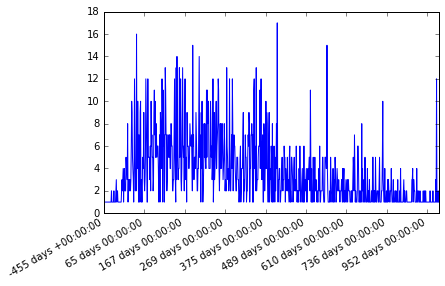

In [46]:
permit_sample['Application Time'].value_counts().sort_index().plot()

Save it.

In [48]:
permit_sample.to_csv("application_permit_join_sample.csv")